# Optimization of Nonlocality against CHSH Inequality

### Goal: Find a set of states and measurements that optimally violate the CHSH inequality.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


### Setup the Quantum Circuits

In [2]:
# The CHSH scenario only requires two qubits ("a" and "b") to simulate
dev = qml.device("default.qubit", wires=["a", "b"])

# optimizer
opt = qml.GradientDescentOptimizer()

@qml.qnode(dev)
def real_chsh_circuit(a_state, b_state, a_measurement, b_measurement):  
    """
    Ansatz circuit where states and measurents are free to rotate about the y-axis.
    In this model, all quantum states real.

    Args:
        a_state (float) : local rotation angle on Alice's state
        b_state (float) : local rotation angle on Bob's state
        a_measurement (float) : rotation angle of Alice's measurement
        b_measurement (float) : rotation angle of Bob's measurement
    """
    qml.Hadamard(wires="a")
    qml.CNOT(wires=["a", "b"])
    
    qml.RY(a_state, wires="a")
    qml.RY(b_state, wires="b")
    
    qml.RY(a_measurement, wires="a")
    qml.RY(b_measurement, wires="b")
    return qml.expval(qml.PauliZ("a") @ qml.PauliZ("b"))

@qml.qnode(dev)
def arbitrary_chsh_circuit(state_settings, measurement_a_settings, measurement_b_settings):
    """
    Ansatz circuit where states are prepared with a two-qubit `ArbitraryUnitary` gate and
    measurements are prepared with a one-qubit `ArbitraryUnitary` gate.

    Args:
        state_settings (list[float]) : 15 angle parameters for the arbitrary two-qubit state.
        measurement_a_settings (list[float]) : 3 angle parameters for Alice's local measurement.
        measurement_b_settings (list[float]) : 3 angle parameters for Bob's local measurement.
    """
    qml.templates.subroutines.ArbitraryUnitary(state_settings, ["a","b"])
    
    qml.templates.subroutines.ArbitraryUnitary(measurement_a_settings, ["a"])
    qml.templates.subroutines.ArbitraryUnitary(measurement_b_settings, ["b"])
    return qml.expval(qml.PauliZ("a") @ qml.PauliZ("b"))

### Setup methods to randomize initial conditions

In [3]:
def real_chsh_rand_settings():
    """
    Returns a (3,2) tensor containing random values for the input to `real_chsh_circuit()`.
    """
    return 2*np.pi*np.random.random((3, 2)) - np.pi

def arbitrary_chsh_rand_settings():
    """
    Returns a 27-element list containing random values for the input to `arbitrary_chsh_circuit()`.
    """
    return 2*np.pi*np.random.random(27) - np.pi

### Setup the Cost Function

In [4]:
def real_chsh_cost(real_settings):
    """
    Applies the CHSH inequality as a cost function with respect to the `real_chsh_circuit()`.
    """
    run1 = real_chsh_circuit(real_settings[0,0], real_settings[0,1], real_settings[1, 0], real_settings[2, 0])
    run2 = real_chsh_circuit(real_settings[0,0], real_settings[0,1], real_settings[1, 0], real_settings[2, 1])
    run3 = real_chsh_circuit(real_settings[0,0], real_settings[0,1], real_settings[1, 1], real_settings[2, 0])
    run4 = real_chsh_circuit(real_settings[0,0], real_settings[0,1], real_settings[1, 1], real_settings[2, 1])
    return -(run1 + run2 + run3 - run4)
    
def arbitrary_chsh_cost(arb_settings):
    """
    Applies the CHSH inequality as a cost function with respect to the `arbitrary_chsh_circuit()`.
    """
    run1 = arbitrary_chsh_circuit(arb_settings[0:15], arb_settings[15:18], arb_settings[21:24])
    run2 = arbitrary_chsh_circuit(arb_settings[0:15], arb_settings[15:18], arb_settings[24:27])
    run3 = arbitrary_chsh_circuit(arb_settings[0:15], arb_settings[18:21], arb_settings[21:24])
    run4 = arbitrary_chsh_circuit(arb_settings[0:15], arb_settings[18:21], arb_settings[24:27])
    return -(run1 + run2 + run3 - run4)

### Optimizing the CHSH circuit over the real parameter space

In [5]:
# initial settings
real_settings = real_chsh_rand_settings()
real_scores = []

# performing gradient descent
for i in range(500):
    real_settings = opt.step(real_chsh_cost, real_settings)
    score = -(real_chsh_cost(real_settings))
    real_scores.append(score)
    
    if i%50 == 0:
        print("iteration : ",i, ", score : ", score)
        print("settings :\n", real_settings, "\n")

# printing final results    
print("final score : ", score,",")
print("final settings : ", real_settings)

iteration :  0 , score :  -0.7011560966086874
settings :
 [[ 0.70758347 -2.96126647]
 [ 0.36507171  2.64109091]
 [ 0.08269264  1.44053703]] 

iteration :  50 , score :  1.516551297558359
settings :
 [[ 0.39655897 -2.65024197]
 [ 0.22007538  2.47506274]
 [-0.37044485  2.20469903]] 

iteration :  100 , score :  2.103360517410068
settings :
 [[ 0.40715582 -2.66083882]
 [ 0.15322866  2.55250631]
 [-0.74080206  2.56445938]] 

iteration :  150 , score :  2.4586018403762977
settings :
 [[ 0.47785794 -2.73154094]
 [ 0.28416668  2.49227041]
 [-1.0424089   2.79536411]] 

iteration :  200 , score :  2.7037564350511962
settings :
 [[ 0.52447234 -2.77815534]
 [ 0.44120042  2.38185108]
 [-1.26457532  2.97091612]] 

iteration :  250 , score :  2.7952826920712806
settings :
 [[ 0.54074335 -2.79442635]
 [ 0.53911905  2.30020346]
 [-1.39042885  3.08049865]] 

iteration :  300 , score :  2.8202460748648273
settings :
 [[ 0.545069   -2.798752  ]
 [ 0.58918805  2.25446011]
 [-1.4536153   3.13935945]] 

ite

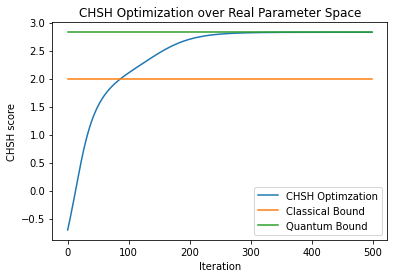

In [6]:
# Plot the individual observables
plt.plot(range(500), real_scores , label = "CHSH Optimzation")
plt.plot(range(500), [2]*500, label = "Classical Bound")
plt.plot(range(500), [2*np.sqrt(2)]*500, label = "Quantum Bound")
plt.title("CHSH Optimization over Real Parameter Space")
plt.xlabel("Iteration")
plt.ylabel("CHSH score")
plt.legend()
plt.show()

### Optimizing the CHSH circuit over general parameter space

In [7]:
# optimizing arbitrary unitary circuit
arbitrary_settings = arbitrary_chsh_rand_settings()
arb_scores = []

# performing gradient descent
for i in range(500):
    arbitrary_settings = opt.step(arbitrary_chsh_cost, arbitrary_settings)
    score = -(arbitrary_chsh_cost(arbitrary_settings))
    arb_scores.append(score)
    
    if i%50 == 0:
        print("iteration : ",i, ", score : ", score)
        print("settings :\n", arbitrary_settings, "\n")

# printing final results    
print("final score : ", score,",")
print("final settings : ", arbitrary_settings)

iteration :  0 , score :  0.8837076630160432
settings :
 [-1.23179723 -1.04879025  2.66687117  0.55997136 -1.93005028 -0.32854597
  2.92858081  3.04087202 -1.79802396  2.04939637  1.92597529 -0.10948375
 -1.24851355 -2.53837217  1.81215544 -1.14709777  1.00182415  2.87945331
 -0.36434714  0.84155464 -2.51367895  1.79500495  0.86588346 -2.33802631
  0.91894695  0.52385731 -2.83805503] 

iteration :  50 , score :  2.3198436193852006
settings :
 [-1.35462833 -1.00443427  2.47737495  0.36097905 -1.95417578 -0.34628327
  2.84945928  3.07195005 -1.6444189   2.03770345  1.86789217 -0.29364613
 -1.27606646 -2.50101087  1.64908269 -1.17787373  0.7154569   2.87945331
 -0.35336672  1.13853963 -2.51367895  1.73572039  1.1707763  -2.33802631
  1.06234043  0.43864793 -2.83805503] 

iteration :  100 , score :  2.592640773312755
settings :
 [-1.36472808 -0.99802383  2.45279067  0.36168062 -1.89477971 -0.41179106
  2.807138    3.07079107 -1.59080987  2.03725847  1.85225621 -0.26858621
 -1.27388335 -2.4

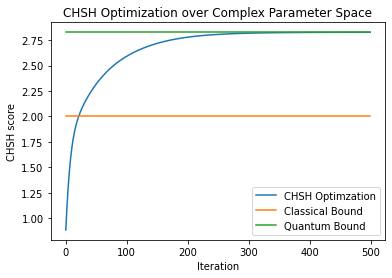

In [8]:
# Plot the individual observables
plt.plot(range(500), arb_scores , label = "CHSH Optimzation")
plt.plot(range(500), [2]*500, label = "Classical Bound")
plt.plot(range(500), [2*np.sqrt(2)]*500, label = "Quantum Bound")
plt.title("CHSH Optimization over Complex Parameter Space")
plt.xlabel("Iteration")
plt.ylabel("CHSH score")
plt.legend()
plt.show()